Development of Live Ocean interpolation functions

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

from scipy import interpolate

import glob

from salishsea_tools import viz_tools
import grid

%matplotlib inline

# Function definitions

Some helper funcions for the interpolation.

In [2]:
# I would prefer to do this with xarray but I'm having issues with units in the boundary files. 
def load_SalishSea_boundary_grid(
    fname='/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc'
):
    """Load the Salish Sea NEMO model boundary depth, latitudes and longitudes:
    
    :arg fname: name of boundary file
    :type fname: str
    
    :returns: numpy arrays depth, lon, lat and a tuple shape
    """
    
    f = nc.Dataset(fname)
    depth = f.variables['deptht'][:]
    lon = f.variables['nav_lon'][:]
    lat = f.variables['nav_lat'][:]
    # determine lateral shape of boundary because arrays are flattened
    width = f.variables['nbrdta'][:].flatten()[-1] + 1
    length = int(f.variables['nbrdta'][:].shape[-1]/width)  # error if result is not an integer???
    shape = (width, length)
    
    return depth, lon, lat, shape

In [3]:
def load_LiveOcean(files, resample_interval = '1H'):
    """Load a time series of Live Ocean results represented by a list of files. 
    Time series is resampled by averaging over resample_interval.  Default is 1 hour.
    
    :arg files: Live Ocean filenames
    :type files: list of strings
    
    :arg resample_interval: interval for resampling based on pandas values.
                            e.g. 1H is one hour, 7D is seven days, etc
    :type resample_interval: str
    
    :returns: xarray dataset of live ocean results
    """
    # Loop through files and load
    d = xr.open_dataset(files[0])
    for f in files[1:]:
        with xr.open_dataset(f) as d1:
            d =xr.concat([d, d1], dim='ocean_time', data_vars='minimal')
    # Determine z-rho (depth)
    G, S, T = grid.get_basic_info(files[0])
    z_rho = np.zeros(d.salt.shape)
    for t in np.arange(z_rho.shape[0]):
        zeta = d.zeta.values[t, : , :]
        z_rho[t, :, :, :] = grid.get_z(G['h'], zeta, S)
    # Add z_rho to dataset
    zrho_DA = xr.DataArray(z_rho, dims = ['ocean_time', 's_rho', 'eta_rho', 'xi_rho'],
                           coords = {'ocean_time': d.ocean_time.values[:],
                                     's_rho': d.s_rho.values[:],
                                     'eta_rho': d.eta_rho.values[:],
                                     'xi_rho': d.xi_rho.values[:]},
                           attrs = {'units': 'metres',
                                    'positive': 'up',
                                    'long_name': 'Depth at s-levels',
                                    'field': 'z_rho ,scalar'})
    d = d.assign(z_rho = zrho_DA)
    # Resample
    d = d.resample(resample_interval, 'ocean_time')
    
    return d

In [4]:
def interpolate_to_NEMO_depths(dataset, NEMO_depths, var_names):
    """Interpolate variables in var_names from a Live Ocean dataset to NEMO depths.
    LiveOcean land points (including points lower than bathymetry) are set to np.nan and then masked. 
    
    :arg dataset: Live Ocean dataset
    :type dataset: xarray Dataset
    
    :arg NEMO_depths: NEMO model depths
    :type NEMO_depths: 1D numpy array
    
    :arg var_names: list of Live Ocean variable names to be interpolated, e.g ['salt', 'temp]'
    :type var_names: list of str
    
    :returns: dictionary continaing interpolated numpy arrays for each variable
    """
    interps = {}
    for var_name in var_names:
        var_interp = np.zeros(dataset[var_name].shape)
        for t in np.arange(var_interp.shape[0]):
            for j in np.arange(var_interp.shape[2]):
                for i in np.arange(var_interp.shape[3]):
                    LO_depths = dataset.z_rho.values[t, :, j, i] 
                    var = dataset[var_name].values[t, :, j, i]
                    var_interp[t, :, j, i] = np.interp(-NEMO_depths, LO_depths, var, left=np.nan)
                    # NEMO depths are positive, LiveOcean are negative
        interps[var_name] = np.ma.masked_invalid(var_interp)
    
    return interps

In [5]:
def fill_NaNs_with_nearest_neighbour(data, lons, lats):
    """At each depth level and time, fill in NaN values with nearest lateral neighbour. 
    The last two dimensions of data are the lateral dimensions. 
    lons.shape and lats.shape = (data.shape[-2], data.shape[-1])
    
    :arg data: the data to be filled
    :type data: 4D numpy array 
    
    :arg lons: longitude points
    :type lons: 2D numpy array
    
    :arg lats: latitude points
    :type lats: D numpy array
    
    :returns: a 4D numpy array
    """
    filled = data.copy()
    for t in np.arange(data.shape[0]):
        for k in np.arange(data.shape[1]):
            subdata = data[t, k, :, :]
            mask = np.isnan(subdata)
            points = np.array([lons[~mask], lats[~mask]]).T
            valid_data =subdata[~mask]
            try:
                filled[t,k,mask] = interpolate.griddata(points, valid_data, (lons[mask], lats[mask]),
                                                        method='nearest')
            except ValueError: #  if the whole depth level is NaN, set it equal to the level above
                filled[t, k, :, :] = filled[t, k-1, :, :]
    return filled

In [6]:
def interpolate_to_NEMO_lateral(var_arrays, dataset, NEMOlon, NEMOlat, shape):
    """Interpolates arrays in var_arrays laterally to NEMO grid. 
    Assumes these arrays have already been interpolated vertically.
    NaN values are set to nearest lateral neighbour. 
    If a vertical level is entirely NaNs, it is set equal to the level above. 
    
    :arg var_arrays: dictionary of 4D numpy arrays. Key represents the variable name.
    :type var_arrrays: dictionary
    
    :arg dataset: LiveOcean results. Used to look up lateral grid.
    :type dataset: xarray Dataset
    
    :arg NEMOlon: array of NEMO boundary longitudes
    :type NEMOlon: 1D numpy array
    
    :arg NEMOlat: array of NEMO boundary longitudes
    :type NEMOlat: 1D numpy array
    
    :arg shape: the lateral shape of NEMO boundary area.
    :type shape: 2-tuple
    
    :returns: a dictionary, like var_arrays, bit with arrays replaced with interpolated values 
    """
    #reshape our NEMO BC grid to use griddata
    longrid = NEMOlon.reshape(shape)
    latgrid = NEMOlat.reshape(shape)
    NEMO_points = (longrid, latgrid)
    #combine LiveOcean grid to use griddata
    LO_points = np.array([dataset.lon_rho.values[:].flatten(), 
                          dataset.lat_rho.values[:].flatten()]).T
    #interpolate each variable
    interps = {}
    for var_name, var in var_arrays.items():
        var_new = np.zeros((var.shape[0], var.shape[1], 1, shape[0]*shape[1]))
        for t in np.arange(var_new.shape[0]):
            for k in np.arange(var_new.shape[1]):
                var_grid = var[t, k, :, :]
                var_interp = interpolate.griddata(LO_points, var_grid.flatten(), NEMO_points )
                var_new[t, k, 0, :] = var_interp.flatten()
        interps[var_name] = fill_NaNs_with_nearest_neighbour(var_new, NEMOlon, NEMOlat)
    
    return interps

## 1.  Load our boundary

In [7]:
depBC, lonBC, latBC, shape = load_SalishSea_boundary_grid()

## 2. Load Live Ocean

In [8]:
base = '/ocean/nsoontie/MEOPAR/LiveOcean/*/*UBC.nc'
files = glob.glob(base)
files.sort()

weekly = load_LiveOcean(files, resample_interval='7D')

## 3. Interpolate

### a. Depths
First, interpolate onto our model level depths. Points below Lieve Ocean bathymetry and on land are set to NaN and masked.

In [9]:
depth_interps = interpolate_to_NEMO_depths(weekly, depBC, ['salt', 'temp'])

Check depth interpolation by comparing a few Live Ocean slices to depth_interps

In [10]:
def compare_depth_interp(dataset, interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir,
                          lims = {'lat': [48.3,48.8], 'lon': [-125.1,-124.4]}):
    # Live Ocean Bathymetry
    fname = '/ocean/nsoontie/MEOPAR/LiveOcean/20160601/ocean_his_0002_UBC.nc'
    G, S, T = grid.get_basic_info(files[0])
    # plottinh
    fig,axs = plt.subplots(1,2,figsize=(15,3))
    # interpolated
    ax=axs[0]
    if sl_dir == 'lat':
        mesh = ax.contourf(dataset.lat_rho.values[:,sl_val], -depBC, interps[var_name][t,:,:,sl_val],
                            levels, cmap='viridis')
        ax.plot(dataset.lat_rho.values[:,sl_val],-G['h'][:,sl_val],'k-')
    else:
        mesh = ax.pcolormesh(dataset.lon_rho.values[sl_val,:], -depBC, interps[var_name][t,:,sl_val,:],
                             vmin=clims[0],vmax=clims[1], cmap='viridis')
        ax.plot(dataset.lon_rho.values[sl_val,:],-G['h'][sl_val,:],'k-')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('interpolated')
    #orginal Live Ocean
    ax=axs[1]
    if sl_dir == 'lat':
        plotting = dataset.isel(xi_rho=sl_val,ocean_time=t)
        dplot = plotting.z_rho.values[:]
        xplot,_ = np.meshgrid(plotting.lat_rho.values[:], dplot[:,0])
    else:
        plotting = dataset.isel(eta_rho=sl_val,ocean_time=t)
        dplot = plotting.z_rho.values[:]
        xplot,_ = np.meshgrid(plotting.lon_rho.values[:], dplot[:,0])
    mesh=ax.contourf(xplot, dplot, plotting[var_name].values[:],
                     levels, cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('original')
    for ax in axs:
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([-450,0])
        ax.set_xlim(lims[sl_dir])
                       
    fig,axs=plt.subplots(1,2,figsize=(15,3))
    ax=axs[0]
    mesh=ax.pcolormesh(dataset.lon_rho.values[:], dataset.lat_rho.values[:], interps[var_name][t,k,:,:],
                       vmin=clims[0],vmax=clims[1], cmap='viridis')
    ax.set_title('interpolated at depth={0:.3g} m'.format(depBC[k]))
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax=axs[1]
    dataset.isel(s_rho=s, ocean_time=t)[var_name].plot(x='lon_rho', y='lat_rho',ax=ax,
                                                       vmin=clims[0],vmax=clims[1], cmap='viridis')
    ax.set_title('original at s_rho {}'.format(dataset.s_rho.values[s]))
    for ax in axs:
        if sl_dir == 'lat':
            ax.plot(dataset.lon_rho.values[:,sl_val], dataset.lat_rho.values[:,sl_val],'k-')
        else:
            ax.plot(dataset.lon_rho.values[sl_val,:], dataset.lat_rho.values[sl_val,:],'k-')
        ax.set_xlabel('long')
        ax.set_ylabel('lat')

Temperature

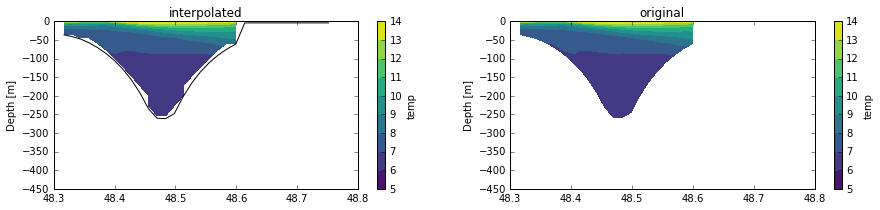

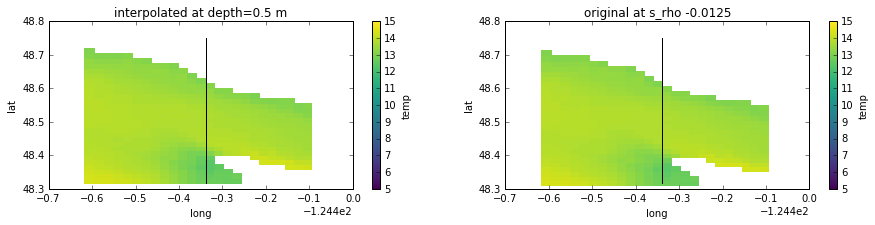

In [11]:
sl_dir = 'lat'
sl_val=13
t=3
s=39; k=0 #these are the values for looking at the surface. It is hard to comapre other depths.
clims=(5, 15)
levels=np.arange(5,15,1)
var_name='temp'
compare_depth_interp(weekly, depth_interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir)

Salt

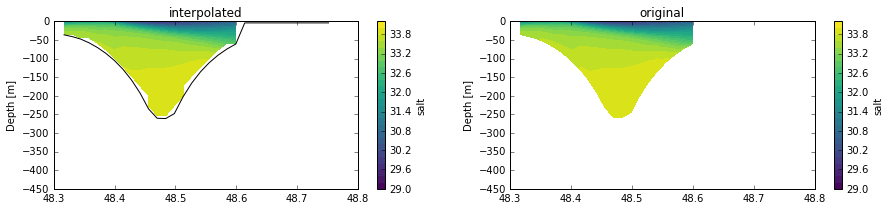

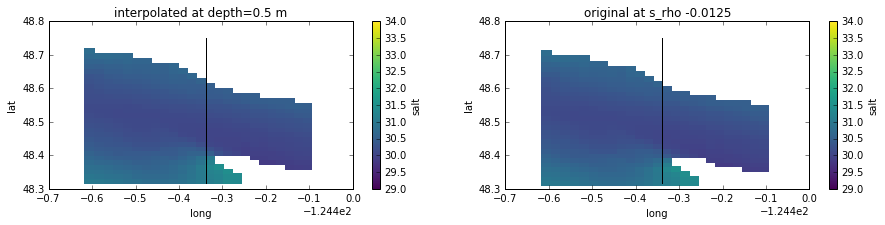

In [12]:
clims=(29, 34)
levels=np.arange(29,34.2,.2)
var_name='salt'
compare_depth_interp(weekly, depth_interps, depBC, var_name, levels, t, s, k, sl_val, sl_dir)

These comparisons look reasonable.

### b. Lateral

Next, interpolate laterally using griddata. Fill NaNs with nearest neighbour.

In [13]:
lateral_interps = interpolate_to_NEMO_lateral(depth_interps, weekly, lonBC, latBC, shape)

Comparisons with depth interpolated Live Ocean

In [14]:
def compare_lateral_interp(d_interps, dataset, l_interps, depths, lons, lats, shape, 
                           var_name, clims, t, k):

    fig,axs = plt.subplots(1,2,figsize=(15,3))
    #Lateral interp
    ax=axs[0]
    longrid = lons.reshape(shape)
    latgrid = lats.reshape(shape)
    mesh=ax.pcolormesh(longrid, latgrid,
                       l_interps[var_name][t, k, :, :].reshape(shape),
                       vmin=clims[0], vmax=clims[1],cmap='viridis')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Laterally interpolated: {0:.3f} m'.format(depths[k]))
    #original lateral grid
    ax=axs[1]
    mesh=ax.pcolormesh(dataset.lon_rho.values[:], dataset.lat_rho.values[:],
                       d_interps[var_name][t, k, :, :],
                       vmin=clims[0], vmax=clims[1],cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('original lateral grid: {0:.3f} m'.format(depths[k]))
    ax.plot([longrid[0,0],longrid[-1,0]], [latgrid[0,0],latgrid[-1,0]], 'k-')
    ax.plot([longrid[0,0],longrid[0,-1]], [latgrid[0,0],latgrid[0,-1]], 'k-')
    ax.plot([longrid[-1,-1],longrid[-1,0]], [latgrid[-1,-1],latgrid[-1,0]], 'k-')
    ax.plot([longrid[0,-1],longrid[-1,-1]], [latgrid[0,-1],latgrid[-1,-1]], 'k-')
    #limits
    for ax in axs:
        ax.set_xlim([-125.1,-124.4])
        ax.set_ylim([48.3,48.8])

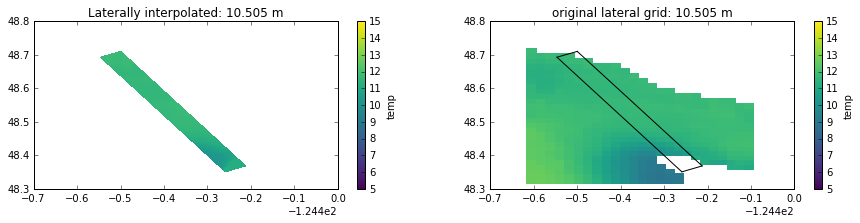

In [15]:
t=0
k=10
clims=(5, 15)
var_name='temp'
compare_lateral_interp(depth_interps, weekly, lateral_interps, depBC, lonBC, latBC, shape,
                       var_name, clims, t, k)

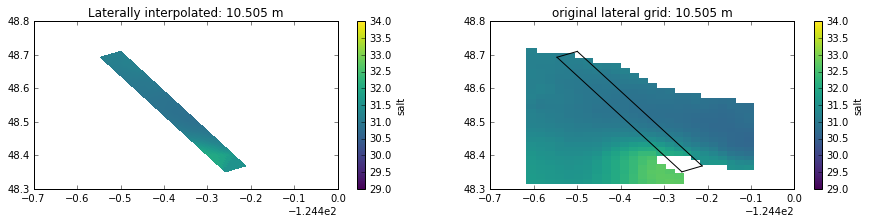

In [16]:
clims=(29, 34)
var_name='salt'
compare_lateral_interp(depth_interps, weekly, lateral_interps, depBC, lonBC, latBC, shape,
                       var_name, clims, t, k)

Again, this looks ok. We have also filled in land points with reasonable values. 

# Compare interpolated Live Ocean and  to current BCs

In [17]:
# Load current BCs
f = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_corrected.nc')
salBC = f.variables['vosaline'][:]
tempBC = f.variables['votemper'][:]
time = f.variables['time_counter'][:]
#fake the dates
start = datetime.datetime(2016,1,1)
dates = [start + datetime.timedelta(weeks=int(d)) for d in time]
b = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = b.variables['Bathymetry'][:]
nbjdta = f.variables['nbjdta'][:] 
nbidta = f.variables['nbidta'][:]

bathyBC = bathy[nbjdta, nbidta]
BC = {'salt': salBC, 'temp': tempBC}

In [18]:
#find time slices to compare
t1=0
t2=21
ts = {'LO': t1, 'NEMO': t2}
#check they are both first week of June
print(weekly.ocean_time.values[t1],dates[t2])

2016-06-01T01:00:00.000000000 2016-06-03 00:00:00


Full BC comparison. First week of June.

In [19]:
def compare_BCs_full(NEMO_BC, LO_interp, depths, tims, bathy, var_name, levels):
    fig,axs = plt.subplots(1,2,figsize=(15,5))
    #Live Ocean
    ax=axs[0]
    mesh=ax.contourf(np.arange(LO_interp[var_name].shape[-1]), depths,
                    LO_interp[var_name][tims['LO'], :, 0, :],
                    levels, cmap='viridis')
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Live Ocean')
    #Our BCs
    ax=axs[1]
    mesh=ax.contourf(np.arange(NEMO_BC[var_name].shape[-1]), depths,
                    NEMO_BC[var_name][tims['NEMO'], :, 0,:], 
                    levels, cmap='viridis')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(var_name)
    ax.set_title('Our BCs')
    #limits and bathy
    for ax in axs:
        ax.set_ylabel('Depth [m]')
        ax.set_ylim(450,0)
        ax.set_xlabel('boundary index')
        ax.plot(np.arange(bathy.shape[1]), bathy[0,:], 'k-')

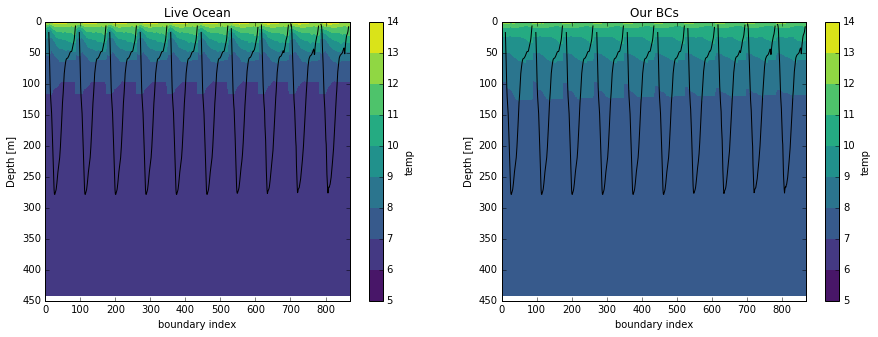

In [20]:
levels=np.arange(5,15,1)
var_name='temp'
compare_BCs_full(BC, lateral_interps, depBC, ts, bathyBC, var_name, levels)

* Black lines are NEMO bathymetry. 
* Live Ocean is cooler below 100m (6-7 deg C vs 7-8 deg C). And warmer in surface.
* A 'colder' current hugs the left boundary in our BCs (raised isotherms). Below 100m in Live Ocean the polarity of the isotherms on the left side reverses. Why?

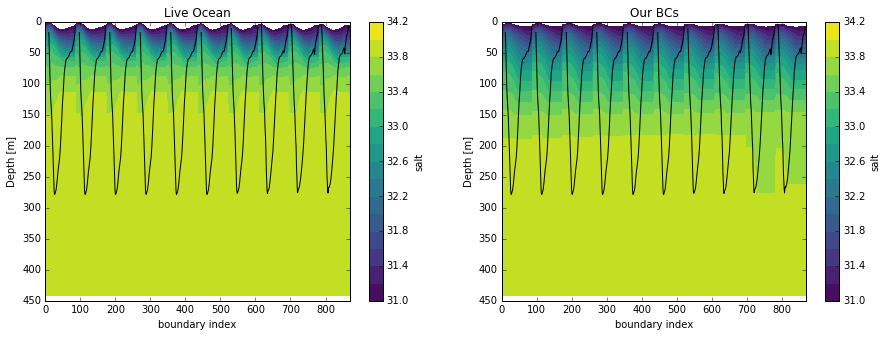

In [21]:
levels=np.arange(31,34.2,.2)
var_name='salt'
compare_BCs_full(BC, lateral_interps, depBC, ts, bathyBC, var_name, levels)

* Same polarity switch in the isohalines...

# Summary
* Given a list of Live Ocean files in chronological order, I  can interpolate onto our boundary with 4 function calls:
    * depBC, lonBC, latBC, shape =  load_SalishSea_boundary()
    * LO_dataset = load_LiveOcean(files, resample_interval='7D') - or choose a different sampling interval
    * depth_interps = interpolate_to_NEMO_depths(LO_dataset, depBC, ['salt', 'temp'])
    * lateral_interps = interpolate_to_NEMO_lateral(depth_interps, LO_dataset, lonBC, latBC, shape)

# Next steps
* For use in model runs, I need to figure out how to save as netCDF. Shouldn't be hard.